# BTC price strategy

In [582]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [583]:
data = pd.read_csv('BTC-USD.csv')

### Adding features

In [584]:
year = []
month=[]
day=[]
for i in data['Date'].values:
    x = i.split('-')
    year.append(int(x[0]))
    month.append(int(x[1]))
    day.append(int(x[2]))
data['Year'] = year
data['Month'] = month
data['Day'] = day

In [585]:
data['Date']=pd.to_datetime(data['Date'])

In [586]:
# prev_score give us the difference between the highest price and the lowest price
data['Prev_close'] = data['Close'].shift(1)
data.dropna(axis=0,inplace=True)
# delta_hl give us the difference between the highest and the actual close
data['delta_hl'] = data['High'] - data['Low']

In [587]:
# This fonction calculate the percentage of the evolution of the price for a day
def pourcentage(df):
    l=[]
    for i in range(len(df.values)):
        x= ((df.iloc[i][1]-df.iloc[i][4]) / df.iloc[i][4]) *100
        l.append(round(x))
    return l
data.insert(column='Variation', value=pourcentage(data),loc=11)

In [588]:
data = data[data['Date'] >= pd.datetime(2022,12,31)]

C:\Users\DELL\AppData\Local\Temp\ipykernel_7100\3727089033.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  data = data[data['Date'] >= pd.datetime(2022,12,31)]


### Data visualisation

In [589]:
data['Variation'].describe()

count    147.000000
mean      -0.299320
std        2.505924
min       -9.000000
25%       -1.000000
50%        0.000000
75%        1.000000
max        7.000000
Name: Variation, dtype: float64

In [590]:
data['Variation'].value_counts().sort_index()

-9     2
-8     1
-7     2
-5     2
-4     7
-3     5
-2    17
-1    19
 0    45
 1    20
 2    12
 3     8
 4     3
 5     3
 7     1
Name: Variation, dtype: int64

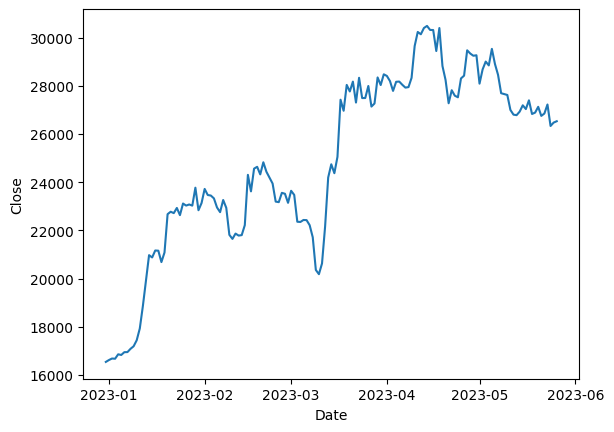

<Axes: xlabel='Date', ylabel='Variation'>

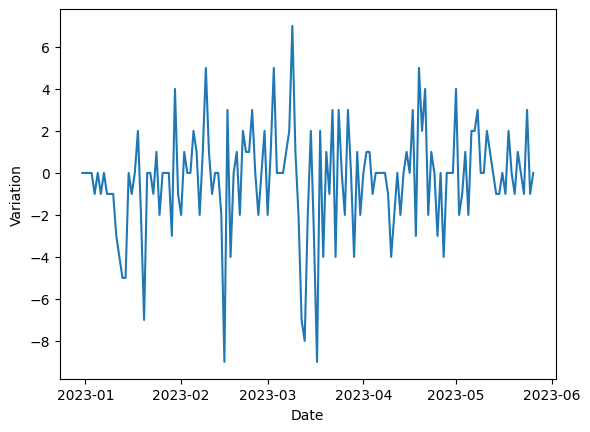

In [591]:
sns.lineplot(data,y='Close',x='Date')
plt.show()
sns.lineplot(data,y='Variation',x='Date')

<Axes: xlabel='Date', ylabel='Variation'>

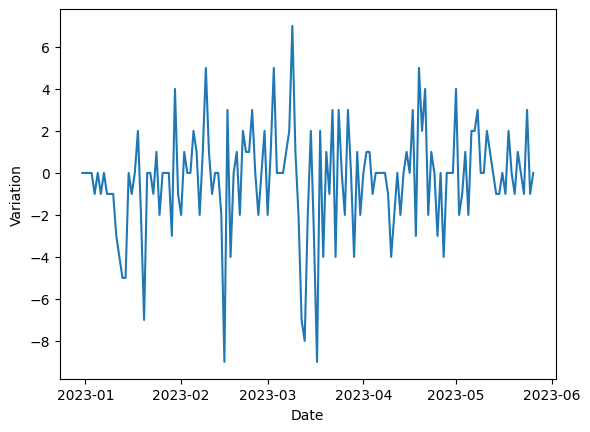

In [592]:
sns.lineplot(data,y='Variation',x='Date')

<Axes: xlabel='Close', ylabel='Variation'>

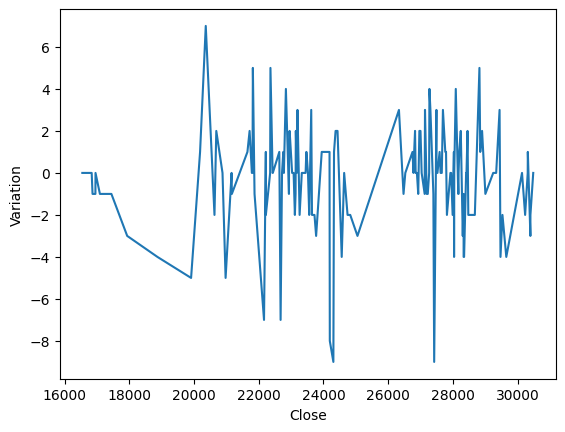

In [593]:
sns.lineplot(data,y='Variation',x='Close')

<Axes: xlabel='Volume', ylabel='Variation'>

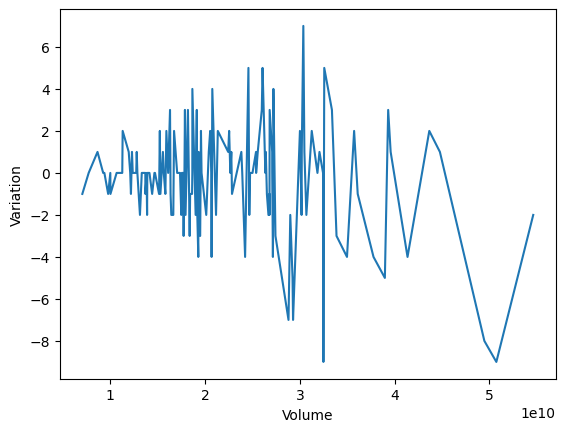

In [594]:
sns.lineplot(data,y='Variation',x='Volume')

<Axes: xlabel='Date', ylabel='Close'>

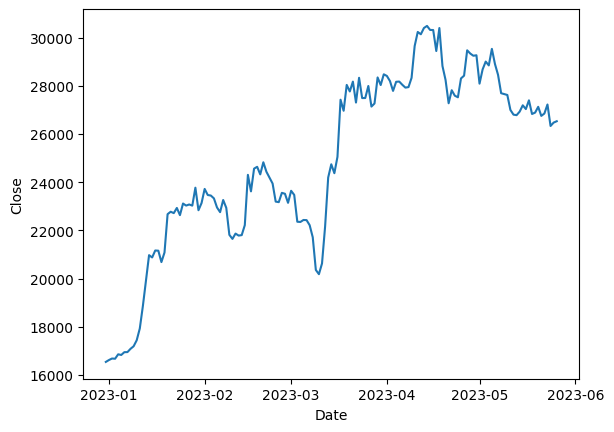

In [595]:
sns.lineplot(data,y='Close',x='Date')

### Preparing the strategy

In [597]:
data.drop(['Close','Date','Variation'],axis=1,inplace=True)

In [598]:
with open('btc_regressor','rb') as f:
    mod = pickle.load(f)

In [599]:
# This fonction calculate the percentage of the evolution of the price for a day
def pourcentage(open,close):
    return (close-open)/open*100

In [600]:
# Converting our dataset in a list and removing the date column
l = data.values.tolist()

### Strategy

In [601]:
class strategie():
    def __init__(self, solde=100, limit= 0):
        self.gain =0
        self.pertes = 0
        self.solde = solde
        self.nb_achat = []
        self.limit = limit
    def achat(self, prix,valeur_btc):
        self.nb_achat.append({valeur_btc:prix})
        self.solde -= prix
    def pourcentage(open,close):
        return (close-open)/open*100
    def vente(self, prix_vente):
        d = self.nb_achat.pop(0)
        prix_achat=list(d.keys())[0]
        prix = d[prix_achat]
        self.solde += pourcentage(prix_achat,prix_vente)/100*prix+prix
        if pourcentage(prix_achat,prix_vente)/100*prix+prix > prix:
            self.gain += pourcentage(prix_achat,prix_vente)/100*prix
        else:
            self.pertes +=pourcentage(prix_achat,prix_vente)/100*prix
    def performences(self):
        print('gain: ',self.gain)
        print('pertes: ',self.pertes)
        print('solde: ',self.solde)
        print('nb_achat: ',self.nb_achat)
    def get_solde(self):
        return self.solde
    def get_nb_achat(self):    
        return len(self.nb_achat)
    def get_limit(self):
        return self.limit

In [640]:
def strategy(df,S):
    m = mod.predict(df)
    m = m.tolist()
    for i in range(len(m)):
        if S.get_solde == 0:
            return S.performences()
        if pourcentage(df.iloc[i][0],m[i]) <=0  and S.get_solde() > S.get_limit():
            S.achat((20/100)*S.get_solde(),df.iloc[i][0])
        if pourcentage(df.iloc[i][0],m[i])>=3 and S.get_nb_achat()>0:
            S.vente(m[i])
    for i in range(S.get_nb_achat()):
        S.vente(m[-1])
    return S.performences()

In [651]:
S=strategie(100,6)
strategy(data,S)

gain:  40.15338965485344
pertes:  -2.6527394535781377
solde:  137.5006502012753
nb_achat:  []
